# Automated Detection of Internally Displaced Person (IDP) Shelters

### Download AoI Image from Google Cloud Storage 

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt

### Setup Arguments and Environment

In [24]:
# get repo root path
import os

# construct remote path
repo = 'idp-master'
cwd = os.getcwd() 
root_path = cwd [ : cwd.find( repo ) + len( repo ) ]
print ( root_path )

C:\Users\KaziMomin.Ashraf\OneDrive - Satellite Applications Catapult\Documents\GitHub\idp-master


In [25]:
# add to system path
import sys
sys.path.insert(0,root_path)

In [41]:
import glob

# initialise arguments
image_pathname = 'D:\catapult_stuff\data\G6\G6_compy.tif'
out_pathname = 'blobs.shp' 
threshold = 900 # 16bit binary threshold 

In [42]:
# import localiser class and create instance
from src.morph.localiser import CentroidLocaliser
obj = CentroidLocaliser()

# open image file
image = obj.openImageFile( image_pathname )
band = image[ 'band' ].ReadAsArray()

# create output shapefile
centroids = obj.createOutputFile( out_pathname, image )

### Visualise AoI Image

<IPython.core.display.Javascript object>


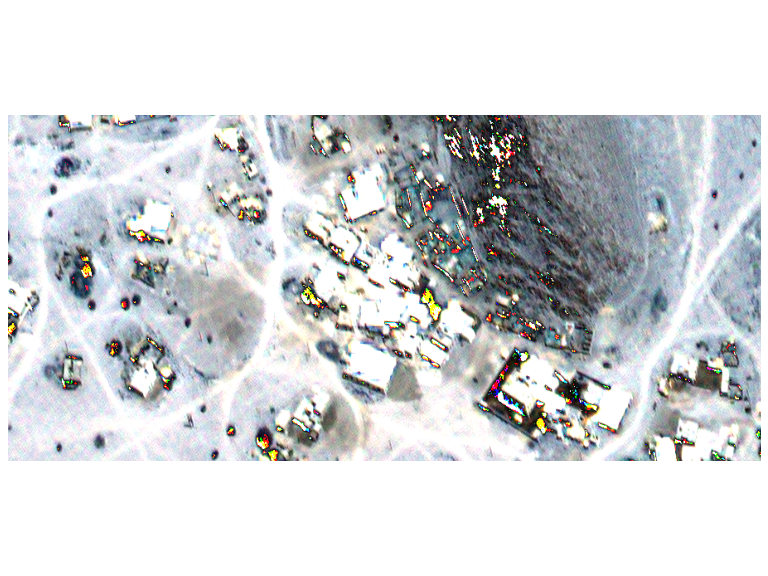

In [51]:
import gdal
import numpy as np

# create figure
fig = plt.figure()

# read image
ds = gdal.Open( image_pathname )
rgb = ds.ReadAsArray()
rgb = np.transpose( rgb, ( 1, 2, 0 ) )

# rescale 16bit to 8bit
for idx in range( ds.RasterCount ):
    p = np.percentile( rgb[ :,:,idx ], [ 2, 98 ] )
    rgb[ :,:,idx] = ( rgb[ :,:,idx ] - p[ 0 ] ) / ( p[ 1 ] - p[ 0 ] ) * 255.0
    rgb[ :,:,idx] = np.clip ( rgb[ :,:,idx], 0.0, 255.0 )

# show image
plt.gca().imshow( rgb )

# remove axis labels
plt.axis('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

fig.subplots_adjust(0.01,0.01,0.99,0.99)
plt.show()

### Apply Opening Transformation to Binary Threshold AoI Image

In [44]:
import numpy as np

# generate thresholded binary image
idx = band > threshold
mask = np.zeros_like( band )
mask[ idx ] = 1

In [45]:
import cv2

# grab kernel and apply open operation
kernel = cv2.getStructuringElement( cv2.MORPH_RECT, (5,5) )
mask_open = cv2.morphologyEx( mask, cv2.MORPH_OPEN, kernel, iterations=1 )

### Visualise RGB Image with Binary Blob Map

<IPython.core.display.Javascript object>


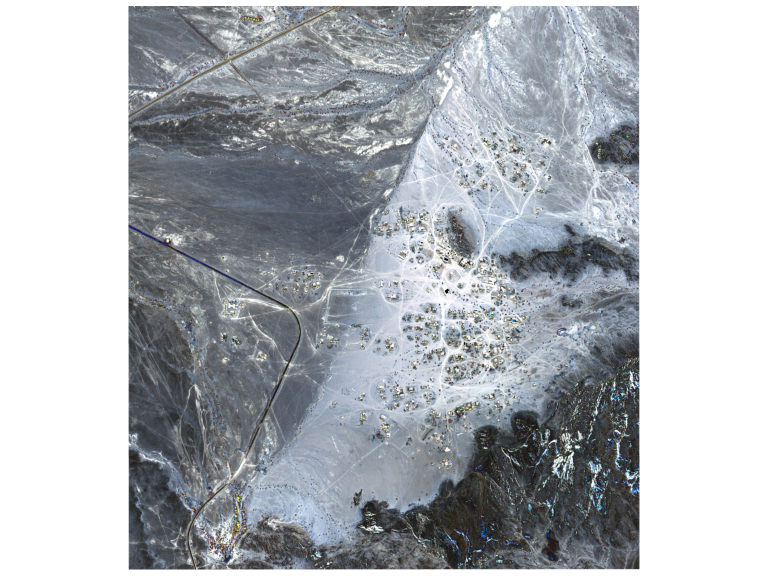

In [46]:
# create figure
fig = plt.figure()

# show image
plt.gca().imshow( mask )

rgb_copy = np.copy ( rgb )
rgb_copy[ np.where ( mask == 1 ) ] = 0
plt.gca().imshow( rgb_copy )

# remove axis labels
plt.axis('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

fig.subplots_adjust(0.01,0.01,0.99,0.99)
plt.show()


### Compute and Visualise Blob Label Image

In [47]:
from skimage.measure import label

# label blob map
labels = label( mask_open )
print ( 'Blobs found: {}'.format( np.amax( labels ) ) )

Blobs found: 46


<IPython.core.display.Javascript object>


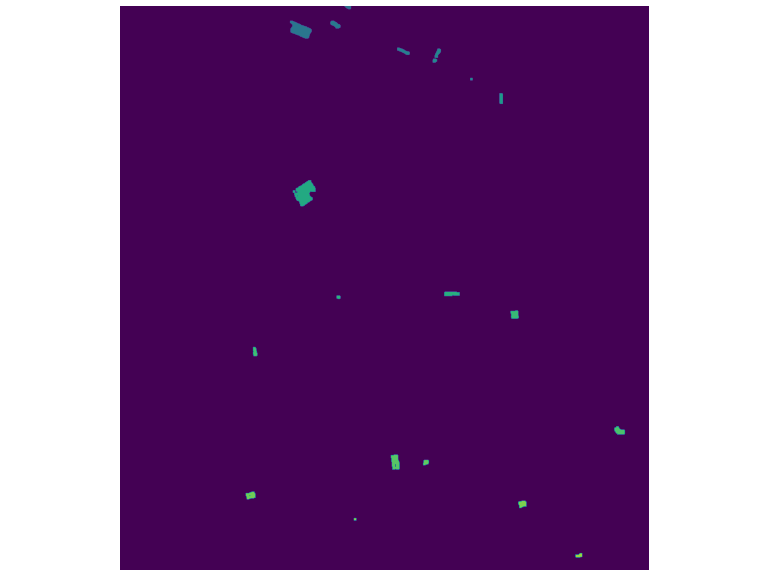

In [48]:
# create figure
fig = plt.figure()

# show image
plt.gca().imshow( labels )

# remove axis labels
plt.axis('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

fig.subplots_adjust(0.01,0.01,0.99,0.99)
plt.show()

### Compute and Visualise Blob Centroid Coordinates

In [49]:
# for each label id
img_x = []; img_y = []
for idx in range( 1, np.amax( labels ) + 1 ):

    coords = np.nonzero( labels == idx )
    
    # find location of blob with current label
    if len ( coords[ 0 ] ) < obj._maxBlobSize:

        # create shapely point object
        img_x.append( np.mean( coords[ 1 ] ) )
        img_y.append( np.mean( coords[ 0 ] ) )

<IPython.core.display.Javascript object>


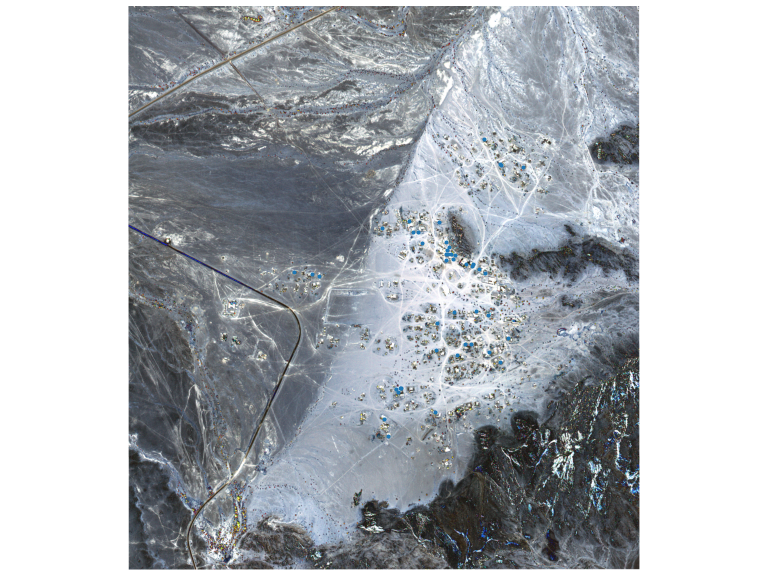

In [50]:
# create figure
fig = plt.figure()

# show image
plt.gca().imshow( rgb )
plt.gca().scatter( x=img_x, y=img_y, s=2)

# remove axis labels
plt.axis('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

fig.subplots_adjust(0.01,0.01,0.99,0.99)
plt.show()

### Export Centroid Coordinates to Shapefile

In [38]:
import ogr 
from shapely.geometry import Point

# for each centroid
for idx in range( 0, len( img_x ) ):

    # compute geo coordinates
    geo_x = ( img_x[ idx ] * image[ 'transform' ][ 1 ] ) + image[ 'transform' ][ 0 ]
    geo_y = ( img_y[ idx ] * image[ 'transform' ][ 5 ] ) + image[ 'transform' ][ 3 ]

    # create new feature (attribute and geometry)
    feature = ogr.Feature( centroids[ 'defn' ] )
    feature.SetField( 'id', idx )

    # create geometry from shapely object
    geom = ogr.CreateGeometryFromWkb( Point( geo_x, geo_y ).to_wkb() )
    feature.SetGeometry(geom)

    centroids[ 'layer' ].CreateFeature( feature )

# flush cache
centroids[ 'ds' ] = None
